In [1]:
from pathlib import Path
import json
from collections import Counter
from tqdm import tqdm
import requests
import re
from collections import Counter
import sys

In [2]:
sys.path.append("..")

In [3]:
import pandas as pd
import numpy as np

In [4]:
path_to_geo_data = Path("../data/geo_api_download_all_v3_4.json")

In [5]:
p = re.compile(r"!(.*?) = (.*)")
affil_data = []
total = 91476
with path_to_geo_data.open("r") as f:
    for line in tqdm(f, total=total):
        rec = json.loads(line)
        acc = rec["acc_no"]
        item = rec["api_response"]
        row = {"acc": acc}
        for m in p.findall(item):
            for field_str in ["contact_institute", "contact_department", "contact_laboratory", "contact_city", "contact_state", "contact_country"]:
                if field_str in m[0]:
                    row[field_str] = m[1]
        affil_data.append(row)
df_geo_affil = pd.DataFrame(affil_data).set_index("acc", verify_integrity=True)

100%|██████████| 91476/91476 [00:10<00:00, 8880.68it/s] 


In [6]:
df_geo_affil_dedup = df_geo_affil.reset_index()[["contact_institute", "contact_city", "contact_state", "contact_country"]].dropna(subset=["contact_institute"]).drop_duplicates().sort_values("contact_institute")

In [7]:
# df_geo_affil_dedup.to_csv("df_geo_affil_dedup.csv", index=True)

In [8]:
# load corpus data
df_corpus = pd.read_parquet('../data/df_2025-02-01-data-citation-corpus-v3.0.parquet')

In [9]:
df_corpus_geo = df_corpus[df_corpus["repository"]=="Gene Expression Omnibus (GEO)"]

In [10]:
print(len(df_corpus_geo))
print(df_corpus_geo["dataset"].nunique())
print(df_corpus_geo["publication"].nunique())

200819
91476
88451


In [11]:
# out = df_corpus_geo["publication"].dropna().drop_duplicates()
# out = out[out.str.lower()!="none"]
# out = out.str.replace("https://doi.org/", "")
# out.to_csv("dois_citing_geo.txt", index=False, header=False)

In [12]:
from openalex_utils import get_openalex_dataframe_from_multiple_works_files, get_ror_map_from_institutions_file

In [13]:
ror_map = get_ror_map_from_institutions_file("../data/openalex_data_20250130/openalex_institutions.gz")
df_openalex = get_openalex_dataframe_from_multiple_works_files("../data/geo_citations_openalex_pub_data_20250521/", ror_map=ror_map)
df_openalex = df_openalex.drop_duplicates(subset=["doi"])

In [14]:
df_openalex

,doi,pmid,pmcid,publication_date,is_oa,oa_url,type,type_crossref,institutions,institutions_ror,lineage,funders,datasets,cited_by_count,primary_topic,topic_subfield,topic_field,topic_domain,lineage_ror
openalex_id,,,,,,,,,,,,,,,,,,,
W2590390825,10.1084/jem.20162024,28232471,5339682,2017-02-23,True,https://rupress.org/jem/article-pdf/214/3/579/...,article,journal-article,"[I139290212, I2750212522, I27577105, I28013169...","[02qz8b764, 054225q67, 05qghxh33, 03phm3r45, 0...","[I139290212, I2750212522, I27577105, I28013169...","[Lustgarten Foundation, Cancer Research Founda...",[],1989,Pancreatic and Hepatic Oncology Research,Oncology,Medicine,Health Sciences,"[03pm18j10, 02qz8b764, 03265fv13, 054225q67, 0..."
W2143459396,10.18632/oncotarget.3216,25669979,4467160,2014-12-31,True,https://www.oncotarget.com/article/3216/pdf/,article,journal-article,"[I1294671590, I154526488, I4210150365, I214917...","[0068m0j38, 02feahw73, 04s3t1g37, 0494jpz02, 0...","[I1294671590, I2801316944, I154526488, I421015...",[],[],469,Cancer Immunotherapy and Biomarkers,Oncology,Medicine,Health Sciences,"[02feahw73, 054225q67, 02vjkv261, 04s3t1g37, 0..."
W3092537844,10.1038/s41586-020-2776-9,33029001,7116869,2020-10-07,True,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,article,journal-article,"[I1850255, I860889466, I127128434, I12708293]","[002n09z45, 02s6k3f65, 01bmjkv45, 017136v53]","[I1850255, I1283582996, I860889466, I127128434...",[],[],226,Cancer Cells and Metastasis,Oncology,Medicine,Health Sciences,"[02s6k3f65, 02f9zrr09, 01bmjkv45, 017136v53, 0..."
W2033052459,10.1371/journal.pone.0050141,23251360,3676315,2012-12-10,True,https://journals.plos.org/plosone/article/file...,article,journal-article,"[I1334819555, I40347166, I39422238]","[024mw5h28, 02mpq6x41, 02yrq0923]","[I1334819555, I40347166, I39422238]",[],[],196,MicroRNA in disease regulation,Cancer Research,"Biochemistry, Genetics and Molecular Biology",Life Sciences,"[02yrq0923, 024mw5h28, 02mpq6x41]"
W1891896752,10.1186/s13073-015-0225-4,26449484,4599317,2015-10-08,True,https://doi.org/10.1186/s13073-015-0225-4,article,journal-article,"[I123387679, I4210134885, I141777705]","[02sy3xj90, 01gckhp53, 048a87296]","[I123387679, I4210125843, I4210134885, I141777...","[Hjärnfonden, Stiftelsen Lars Hiertas Minne, F...",[],141,Epigenetics and DNA Methylation,Molecular Biology,"Biochemistry, Genetics and Molecular Biology",Life Sciences,"[048a87296, 028hv5492, 02sy3xj90, 01gckhp53]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2744098089,10.3892/ol.2017.6723,28943924,5592848,2017-08-04,True,https://www.spandidos-publications.com/ol/14/4...,article,journal-article,"[I4210153930, I4210089318]","[006qwan38, 045kpgw45]","[I4210153930, I4210089318]",[],[],6,Computational Drug Discovery Methods,Computational Theory and Mathematics,Computer Science,Physical Sciences,"[045kpgw45, 006qwan38]"
W3127318083,10.3389/fcell.2020.608112,33634099,7900515,2021-02-09,True,https://www.frontiersin.org/articles/10.3389/f...,article,journal-article,[I204308271],[00qqv6244],[I204308271],[],[],6,Hippo pathway signaling and YAP/TAZ,Cell Biology,"Biochemistry, Genetics and Molecular Biology",Life Sciences,[00qqv6244]
W3183504456,10.3389/fgene.2021.695597,34276798,8283811,2021-07-02,True,https://www.frontiersin.org/articles/10.3389/f...,article,journal-article,"[I160354086, I4210126060]","[03dveyr97, 030sc3x20]","[I160354086, I4210126060]",[],[],5,RNA modifications and cancer,Molecular Biology,"Biochemistry, Genetics and Molecular Biology",Life Sciences,"[03dveyr97, 030sc3x20]"


In [15]:
df_openalex["publication_date"] = pd.to_datetime(df_openalex["publication_date"])

In [18]:
oax_fields_to_merge = [
    "publication_date",
    "is_oa",
    "type",
    "type_crossref",
    "institutions_ror",
    "primary_topic",
    "topic_subfield",
    "topic_field",
    "topic_domain",
    "funders",
    "datasets",
]
to_merge_left = df_corpus_geo.reset_index(names="corpus_id")
to_merge_left["corpus_has_affils"] = to_merge_left["affiliations"].apply(lambda x: len(x) > 0)
to_merge_left["target_upper"] = to_merge_left["dataset"].str.upper()
to_merge_left = to_merge_left.rename(columns={"publication": "DOI"})
to_merge_left = to_merge_left.rename(columns={"funders": "cited_funders", "subjects": "cited_subjects"})
to_merge_left = to_merge_left[["DOI", "target_upper", "corpus_id", "corpus_has_affils", "cited_funders", "cited_subjects"]]
to_merge_right = df_openalex.rename(columns={"doi": "DOI"})[["DOI"] + oax_fields_to_merge].reset_index()
df_merge = to_merge_left.merge(to_merge_right, how="left", on="DOI")

In [21]:
# merge in affiliations downloaded from geo
df_merge = df_merge.merge(df_geo_affil, how="left", left_on="target_upper", right_index=True)

In [23]:
cols_rename = {
    "accession_number": "target",
    "repository_europepmc": "cited_repository",
    "DOI": "citing_doi",
    "openalex_id": "citing_openalex_id",
    "is_oa": "citing_is_oa",
    "type": "citing_openalex_type",
    "institutions_ror": "citing_institutions_ror",
    "primary_topic": "citing_primary_topic",
    "topic_subfield": "citing_topic_subfield",
    "topic_field": "citing_topic_field",
    "topic_domain": "citing_topic_domain",
    "funders": "citing_openalex_funders",
    "datasets": "citing_openalex_datasets",
}
df_merge = df_merge.rename(columns=cols_rename)

In [25]:
df_merge["publication_date"] = pd.to_datetime(df_merge["publication_date"])
df_merge["publication_year"] = df_merge["publication_date"].dt.year

In [30]:
df_merge.to_csv("geo_citations_with_affils_and_openalex.csv", index=False)

In [27]:
df_merge["citing_topic_domain"].value_counts()

citing_topic_domain
Life Sciences        131411
Health Sciences       65913
Physical Sciences      3108
Social Sciences         285
Name: count, dtype: int64

In [28]:
df_merge["citing_topic_field"].value_counts()

citing_topic_field
Biochemistry, Genetics and Molecular Biology    105976
Medicine                                         64920
Immunology and Microbiology                      12046
Agricultural and Biological Sciences              7758
Neuroscience                                      5287
Environmental Science                             1106
Computer Science                                  1015
Nursing                                            509
Engineering                                        461
Pharmacology, Toxicology and Pharmaceutics         344
Dentistry                                          311
Psychology                                         179
Chemistry                                          159
Materials Science                                  140
Health Professions                                 100
Mathematics                                         85
Social Sciences                                     77
Energy                                        

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
field_counts = df_merge["citing_topic_field"].value_counts()
num_colors = len(sns.color_palette())
color_map = {x: sns.color_palette()[i % num_colors] for i, x in enumerate(field_counts.index)}
color_map["other"] = sns.color_palette()[-1]

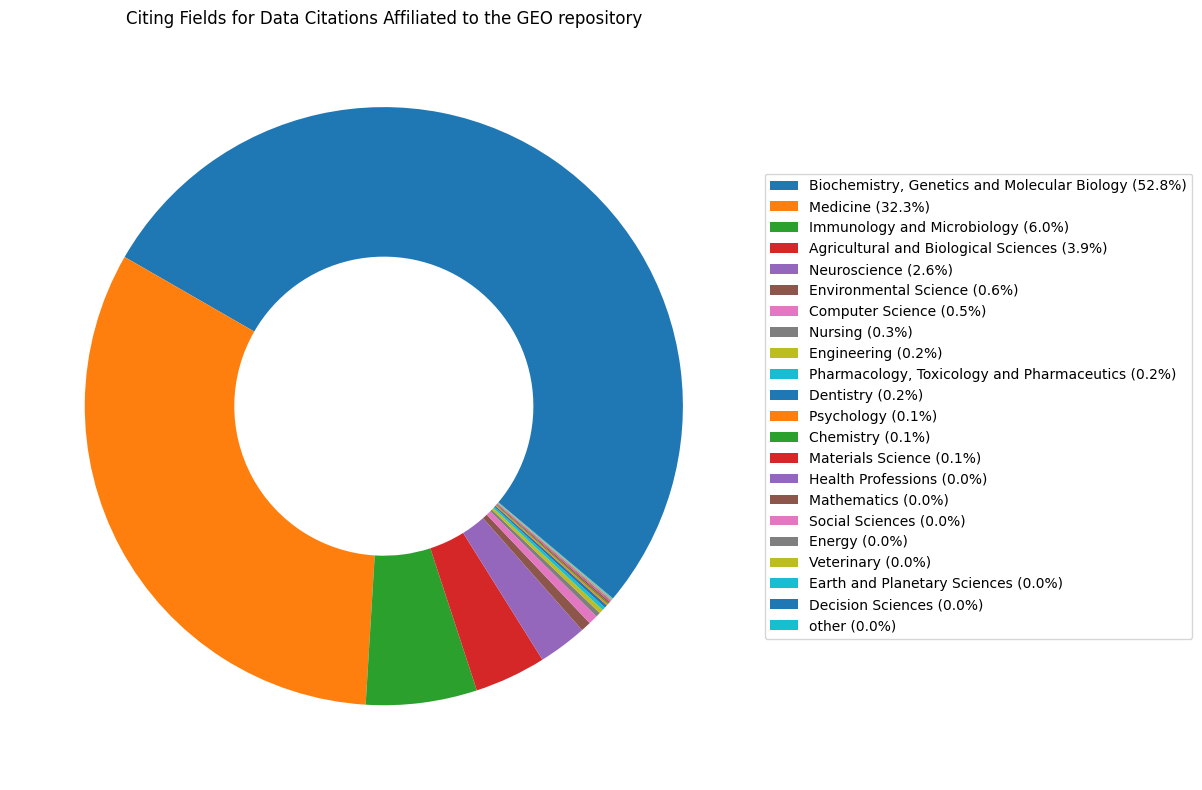

In [39]:
# Inspiration from https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(aspect="equal"))

df_field_counts = df_merge["citing_topic_field"].value_counts().reset_index()
df_field_counts.loc[df_field_counts.index > 20, "citing_topic_field"] = "other"
to_plot = df_field_counts.groupby("citing_topic_field").sum("count")
to_plot = to_plot["count"].sort_values(key=lambda x: x.mask(x.index=="other", 0), ascending=False)  # make sure "other" is on the bottom

colors = [color_map[label] for label in to_plot.index]
wedges, texts = ax.pie(to_plot, wedgeprops=dict(width=0.5), startangle=-40, colors=colors)

pct = to_plot / sum(to_plot)
legend_texts = [f"{field} ({pct.loc[field]:.1%})" for field in to_plot.index]
ax.legend(wedges, legend_texts,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title("Citing Fields for Data Citations Affiliated to the GEO repository")

plt.tight_layout()
plt.show()